# ILD jet processing script
This notebook processes the Refined2Jets, and writes out a couple of quantities in csv files.
The list of quantities is given below.

In [1]:
using LCIO
using DataFrames
using FastJet
using CxxWrap: StdVector
using LinearAlgebra
using CSV
using ProgressMeter

In [2]:
flavorTagDir = readdir("/nfs/dust/ilc/group/ild/miniDST/E250-SetA/ILD/flavortag", join=true)
bbFiles = filter(name -> occursin(r"h_bb",name), flavorTagDir)
ccFiles = filter(name -> occursin(r"h_cc",name), flavorTagDir)
uuFiles = filter(name -> occursin(r"h_uu",name), flavorTagDir)
ddFiles = filter(name -> occursin(r"h_dd",name), flavorTagDir)
ggFiles = filter(name -> occursin(r"h_gg",name), flavorTagDir)
ssFiles = filter(name -> occursin(r"h_ss",name), flavorTagDir)

47-element Array{String,1}:
 "/nfs/dust/ilc/group/ild/miniDST/E250-SetA/ILD/flavortag/ILD-mini-DST-rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I410003.Pn23n23h_ss.eL.pR.n000.d_dstm_14986_0.slcio"
 "/nfs/dust/ilc/group/ild/miniDST/E250-SetA/ILD/flavortag/ILD-mini-DST-rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I410003.Pn23n23h_ss.eL.pR.n000.d_dstm_14986_1.slcio"
 "/nfs/dust/ilc/group/ild/miniDST/E250-SetA/ILD/flavortag/ILD-mini-DST-rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I410003.Pn23n23h_ss.eL.pR.n000.d_dstm_14987_0.slcio"
 "/nfs/dust/ilc/group/ild/miniDST/E250-SetA/ILD/flavortag/ILD-mini-DST-rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I410003.Pn23n23h_ss.eL.pR.n000.d_dstm_14987_1.slcio"
 "/nfs/dust/ilc/group/ild/miniDST/E250-SetA/ILD/flavortag/ILD-mini-DST-rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I410003.Pn23n23h_ss.eL.pR.n000.d_dstm_14987_10.slcio"
 "/nfs/dust/ilc/group/ild/miniDST/E250-SetA/ILD/flavortag/ILD-mini-DST-rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I410003.Pn23n23h_ss.eL.pR.n000.d_d

## CSV file content
For each jet, let's plot
 - btag value
 - ctag value
 - otag value
 - LCFIPlus category
 - the momentum fraction of the leading particle

In [3]:
function particleCounts(fileList)
    ntuple = DataFrame(
        bTag = Float64[],
        cTag = Float64[],
        oTag = Float64[],
        category = Float32[],
        maxFraction = Float64[]
    )
    
    totalEvents = 0
    @showprogress for FILENAME in fileList
        LCIO.open(FILENAME) do reader
            for (iEvent, event) in enumerate(reader)
                totalEvents += 1
                if totalEvents >= 10000
                    break
                end
                jets = getCollection(event, "Refined2Jets")
                if length(jets) < 2
                    continue
                end
                jetPIDh = PIDHandler(jets)
                ilcfi = LCIO.getAlgorithmID(jetPIDh, "lcfiplus")
                ibtag = getParameterIndex(jetPIDh, ilcfi, "BTag") 
                ictag = getParameterIndex(jetPIDh, ilcfi, "CTag") 
                iotag = getParameterIndex(jetPIDh, ilcfi, "OTag") 
                icat = getParameterIndex(jetPIDh, ilcfi, "Category")
                reco = getCollection(event, "PandoraPFOs")
                pfoPIDh = PIDHandler(reco)
                iLikelihoodPID = LCIO.getAlgorithmID(pfoPIDh, "LikelihoodPID")
                for j in jets
                    ituple = []
                    tagList = getParameters(getParticleID(jetPIDh, j, ilcfi))
                    push!(ituple, tagList[ibtag])
                    push!(ituple, tagList[ictag])
                    push!(ituple, tagList[iotag])
                    push!(ituple, tagList[icat])
                    parts = getParticles(j)
                    maxFraction = 0.0
                    for pfo in parts
                        # charged Kaons need PID
                        pid = abs(getType(pfo))
                        if pid == 211
                            iKaonLike::Int64 = getParameterIndex(pfoPIDh, iLikelihoodPID, "kaonLikelihood") 
                            iPionLike::Int64 = getParameterIndex(pfoPIDh, iLikelihoodPID, "pionLikelihood")
                            pidList = getParameters(getParticleID(pfoPIDh, pfo, iLikelihoodPID))
                            if length(pidList) == 0
                                continue
                            end
                            L_pi = pidList[iPionLike]
                            L_K = pidList[iKaonLike]
                            kaonPID = L_K/(L_pi+L_K)
                            if kaonPID < 0.5
                                continue
                            end
                        # K0shorts go through without issues
                        # everything else, we'll skip for now
                        elseif pid != 310
                            continue
                        end
                        if norm(getMomentum(pfo)) > maxFraction
                            maxFraction = norm(getMomentum(pfo))
                        end
                    end
                    maxFraction /= norm(getMomentum(j))
                    push!(ituple, maxFraction)
                    push!(ntuple, ituple)
                end
            end
        end
    end
    return ntuple
end

particleCounts (generic function with 1 method)

In [4]:
bb = particleCounts(bbFiles)
# CSV.write("bb_tagging.csv", bb)
cc = particleCounts(ccFiles)
gg = particleCounts(ggFiles)
ss = particleCounts(ssFiles)
# uu = particleCounts(uuFiles)
# dd = particleCounts(ddFiles)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


,bTag,cTag,oTag,category,maxFraction
,Float64,Float64,Float64,Float32,Float64
1,0.0133605,0.071538,0.915102,16.0,0.00469753
2,0.010838,0.0477847,0.941377,16.0,0.109811
3,0.118955,0.187443,0.693602,16.0,0.169575
4,0.152364,0.391321,0.456315,16.0,0.0520066
5,0.0277324,0.146515,0.825752,16.0,0.0182709
6,0.0925422,0.242456,0.665002,16.0,0.0274581
7,0.0371529,0.198663,0.764184,16.0,0.0851345
8,0.0118235,0.061262,0.926915,16.0,0.105719
9,0.0113219,0.0618402,0.926838,16.0,0.114697


In [5]:
using StatsPlots

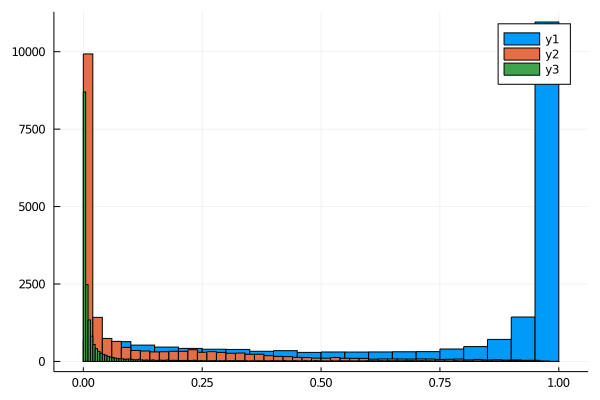

In [10]:
histogram(bb[!, :bTag])
histogram!(bb[!, :cTag])
histogram!(bb[!, :oTag])

In [11]:
# adding columns to capture the sample index
ss[!, :sampleType] .= :ss
bb[!, :sampleType] .= :bb
cc[!, :sampleType] .= :cc
gg[!, :sampleType] .= :gg
# dd.sampleType = :dd
# uu.sampleType = :uu

19998-element Array{Symbol,1}:
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 ⋮
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg
 :gg

In [12]:
allData = vcat(ss, bb, cc, gg)

,bTag,cTag,oTag,category,maxFraction,sampleType
,Float64,Float64,Float64,Float32,Float64,Symbol
1,0.0209384,0.111525,0.867537,16.0,0.175549,ss
2,0.018631,0.0815232,0.899846,16.0,0.0716512,ss
3,0.0107826,0.0695468,0.919671,16.0,0.0810126,ss
4,0.060994,0.312123,0.626883,16.0,0.0104169,ss
5,0.0247918,0.0830112,0.892197,16.0,0.423775,ss
6,0.011766,0.0652778,0.922956,16.0,0.0487804,ss
7,0.0594164,0.0409026,0.899681,17.0,0.0642746,ss
8,0.0080153,0.0456571,0.946328,16.0,0.0924616,ss
9,0.0218083,0.11795,0.860241,16.0,0.057602,ss


In [22]:
sRows = allData.sampleType .== :ss

79992-element BitArray{1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [23]:
sData = allData[sRows, :]

,bTag,cTag,oTag,category,maxFraction,sampleType
,Float64,Float64,Float64,Float32,Float64,Symbol
1,0.0209384,0.111525,0.867537,16.0,0.175549,ss
2,0.018631,0.0815232,0.899846,16.0,0.0716512,ss
3,0.0107826,0.0695468,0.919671,16.0,0.0810126,ss
4,0.060994,0.312123,0.626883,16.0,0.0104169,ss
5,0.0247918,0.0830112,0.892197,16.0,0.423775,ss
6,0.011766,0.0652778,0.922956,16.0,0.0487804,ss
7,0.0594164,0.0409026,0.899681,17.0,0.0642746,ss
8,0.0080153,0.0456571,0.946328,16.0,0.0924616,ss
9,0.0218083,0.11795,0.860241,16.0,0.057602,ss


In [24]:
sData = sData[sData.bTag .> 0.8, :]

,bTag,cTag,oTag,category,maxFraction,sampleType
,Float64,Float64,Float64,Float32,Float64,Symbol
1,0.986564,0.0043202,0.00911582,18.0,0.213085,ss
2,0.887826,0.107009,0.00516475,17.0,0.112558,ss
3,0.844654,0.120312,0.0350337,17.0,0.0128882,ss
4,0.892949,0.0537205,0.0533307,17.0,0.156185,ss
5,0.881271,0.0473935,0.0713353,17.0,0.0571456,ss
6,0.987085,0.0100157,0.00289981,19.0,0.0800115,ss
7,0.97762,0.012784,0.00959613,18.0,0.362592,ss
8,0.85164,0.105783,0.0425775,17.0,0.0588013,ss
9,0.968476,0.00852261,0.0230016,19.0,0.124089,ss


For more in formation, consult <https://dataframes.juliadata.org/stable/man/getting_started/>